<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span>

# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель исследования:**  
Построить модель с предельно большим значением F1-меры (не менее 0.59), чтобы спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

**Ход исследования:**  
* Предобработка данных (удаление ненужных столбцов, замена пропусков)
* Исследование моделей и выбор лучшей из них без учёта дисбаланса классов
* Устранение дисбаланса в классах
* Выбор лучшей модели после устранения дисбаланса
* Финальное тестирование лучшей модели

## Подготовка данных

In [1]:
#Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Сохраним данные в переменной data
data = pd.read_csv('Churn.csv')
#Посмотрим наличие пропусков и тип данных по датафрейму и выведем первые пять строк таблицы на экран
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 10000 entries, 0 to 9999

Data columns (total 14 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   RowNumber        10000 non-null  int64  

 1   CustomerId       10000 non-null  int64  

 2   Surname          10000 non-null  object 

 3   CreditScore      10000 non-null  int64  

 4   Geography        10000 non-null  object 

 5   Gender           10000 non-null  object 

 6   Age              10000 non-null  int64  

 7   Tenure           9091 non-null   float64

 8   Balance          10000 non-null  float64

 9   NumOfProducts    10000 non-null  int64  

 10  HasCrCard        10000 non-null  int64  

 11  IsActiveMember   10000 non-null  int64  

 12  EstimatedSalary  10000 non-null  float64

 13  Exited           10000 non-null  int64  

dtypes: float64(3), int64(8), object(3)

memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#Посмотрим общую информацию по датафрейму
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Промежуточный вывод**

* В столбце **Tenure** есть пропуски. Их можно заполнить медианными значениями.
* Можно удалить столбец **RowNumber**. Он лишний.
* Также можно удалить столбец **Surname**. Он вряд ли влияет на вероятность ухода клиента из банка.
* Столбец **CustomerId** также лишний, удалим и его.

In [4]:
#Удалим столбцы RowNumber, Surname и CustomerId
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [5]:
#Заменим пропуски в столбце Tenure медианными значениями
data.loc[data['Tenure'].isna(), 'Tenure'] = data['Tenure'].median()

In [6]:
#Проверим количество пропусков в датафрейме
data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
#Проверим датафрейм на наличие дубликатов
data.duplicated().sum()

0

In [8]:
#Создадим список из столбцов с числовыми значениями и проверим корреляцию
numbers = ['CreditScore','Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary']
data.loc[:,numbers].corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.003965,-0.000060,0.006268,0.012238,-0.001384
Age,-0.003965,1.000000,-0.012606,0.028308,-0.030680,-0.007201
Tenure,-0.000060,-0.012606,1.000000,-0.007535,0.011409,0.010049
Balance,0.006268,0.028308,-0.007535,1.000000,-0.304180,0.012797
NumOfProducts,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.014204
EstimatedSalary,-0.001384,-0.007201,0.010049,0.012797,0.014204,1.000000


Самая большая корреляция **0.3** есть между столбцами **Age** и **NumOfProducts**, а также между **Balance** и **NumOfProducts**. Она не особо велика, поэтому столбцы можно не трогать.

**Вывод:**  
* Данные загружены и проверены. 
* Дубликатов нет.
* Признаки RowNumber, CustomerId и Surname удалены, так как целевой признак от них не зависит.
* Пропуски в признаке Tenure были заполнены медианными значениями.
* Проверена корреляция признаков, существенной не обнаружено, поэтому столбцы оставили как есть.  
Данные готовы к дальнейшей работе.

## Исследование задачи

In [9]:
#Разделим данные на целевой признак и признаки
features = data.drop('Exited', axis=1)
target = data['Exited']

In [11]:
#Разделим данные на валидационную, обучающую и тестовую выборки
features, features_test, target, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

In [12]:
#Выведем размеры получившихся выборок
print('Размеры выборок:')
print('features_train:', features_train.shape)
print('features_valid:', features_valid.shape)
print('features_test:', features_test.shape)

Размеры выборок:

features_train:  (6000, 10)

features_valid:  (2000, 10)

features_test:   (2000, 10)


In [13]:
#Разобьём признаки на категориальные и количественные
cat_features = ['Geography', 'Gender']
num_features_train = features_train.columns.drop(cat_features).to_list()
     
#Для категориальных признаков применим OHE и проверим результат
features_train = pd.get_dummies(features_train, columns=cat_features, drop_first=True)
print(features_train.shape)
features_train.head(1)

(6000, 11)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
492,639,38,4.0,81550.94,2,0,1,118974.77,0,0,0


In [14]:
#Разобьём признаки на категориальные и количественные
cat_features = ['Geography', 'Gender']
num_features_valid = features_valid.columns.drop(cat_features).to_list()
     
#Для категориальных признаков применим OHE и проверим результат
features_valid = pd.get_dummies(features_valid, columns=cat_features, drop_first=True)
print(features_valid.shape)
features_valid.head(1)

(2000, 11)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2358,669,43,1.0,163159.85,1,0,1,15602.8,0,0,1


In [15]:
#Разобьём признаки на категориальные и количественные
cat_features = ['Geography', 'Gender']
num_features_test = features_test.columns.drop(cat_features).to_list()
     
#Для категориальных признаков применим OHE и проверим результат
features_test = pd.get_dummies(features_test, columns=cat_features, drop_first=True)
print(features_test.shape)
features_test.head(1)

(2000, 11)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7867,640,46,3.0,0.0,1,1,1,156260.08,0,1,0


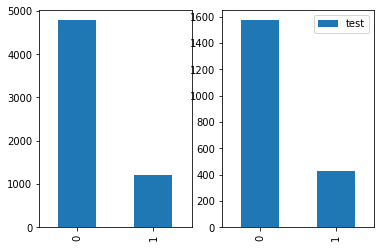

In [16]:
#Проверим дисбаланс целевого класса
f, (ax1, ax2) = plt.subplots(1, 2)
target_train.value_counts().plot(kind='bar', ax=ax1, label='train')
target_test.value_counts().plot(kind='bar', ax=ax2, label='test')
plt.legend()

Дисбаланс классов присутствует. Класс **0** почти в 4 раза превышает класс **1**.

### Решающее дерево

Построим модель решающего дерева с помощью собственной функции  
Гиперпараметры для модели:  
* **max_depth** - максимальная глубина древа  
* **min_samples_split** - минимальное количество объектов в узле  
* **min_samples_leaf** - минимальное количество объектов в листе  
* **criterion** (*gini* или *entropy*) - функция измерения качества разделения  
Критерием проверки качества модели будет **f1**.  

In [17]:
#cw - параметр class_weight для модели решающего дерева

def decision_tree(features_train, features_valid, target_train, target_valid, cw=None):
    
    best_parameters_f1 = []
    best_f1 = 0
    #best_parameters_roc_auc = []
    #best_roc_auc = 0.5
    
    for max_depth in range(2,10):
        for min_samples_split in range(2,6):
            for min_samples_leaf in range(1,10):
                for criterion in ['gini', 'entropy']:
                    model_tree_cl = DecisionTreeClassifier(random_state=12345,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion,
                                                          class_weight=cw)
                    
                    model_tree_cl.fit(features_train, target_train)
                    predictions = model_tree_cl.predict(features_valid)
                    f1 = f1_score(target_valid, predictions)
                    if f1 > best_f1:
                        best_parameters_f1 = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_f1 = f1
                    #roc_auc = roc_auc_score(target_valid, predictions)
                    #if roc_auc > best_roc_auc:
                        #best_parameters_roc_auc = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        #best_roc_auc = roc_auc
    

    print('''Лучшая метрика f1: {}
    Парамтеры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} \n'''.format(round(best_f1, 3),
                                 best_parameters_f1[0],
                                 best_parameters_f1[1],
                                 best_parameters_f1[2],
                                 best_parameters_f1[3]
                                ))
    
    #print('''Лучшая метрика roc_auc: {}
    #Парамтеры модели:
       #max_depth = {}
       #min_samples_split = {}
       #min_samples_leaf = {}
       #criterion = {} '''.format(round(best_roc_auc, 3),
                                 #best_parameters_roc_auc[0],
                                 #best_parameters_roc_auc[1],
                                 #best_parameters_roc_auc[2],
                                 #best_parameters_roc_auc[3]
                                #))

decision_tree(features_train, features_valid, target_train, target_valid)


Лучшая метрика f1: 0.565

    Парамтеры модели:

       max_depth = 7

       min_samples_split = 2

       min_samples_leaf = 7

       criterion = gini 




Лучшая метрика f1 для решающего дерева составляет 0.56, что недостаточно для нашей цели. Рассмотрим другие модели.

### Случайный лес

Построим модель случайного леса с помощью собственной функции.
Гиперпараметры для модели:
* **n_estimators** - количество деревьев
* **max_depth** - максимальная глубина древа
* **min_samples_split** - минимальное количество объектов в узле
* **min_samples_leaf** - минимальное количество объектов в листе  
Критерием проверки качества модели будет **f1**.

In [18]:
#Код выполняется несколько минут
def random_forest(features_train, features_valid, target_train, target_valid, cw=None):
    
    best_parametres_f1 = []
    best_f1 = 0
    #best_parametres_roc_auc = []
    #best_roc_auc = 0.5

    for n_estimators in range(30,40):
        for max_depth in range(10,17,2):
            for min_samples_split in range(2,5):
                for min_samples_leaf in range(1,4):
                    
                    model_forest_cl = RandomForestClassifier(random_state=12345,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf)
                    
                    model_forest_cl.fit(features_train, target_train)
                    predictions = model_forest_cl.predict(features_valid)

                    f1 = f1_score(target_valid, predictions)
                    if f1 > best_f1:
                        best_parametres_f1 = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_f1 = f1

                    #roc_auc = roc_auc_score(target_valid, predictions)
                    #if roc_auc > best_roc_auc:
                        #best_parametres_roc_auc = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        #best_roc_auc = roc_auc

    print('''Лучшая метрика f1: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} \n'''.format(round(best_f1, 3),
                                 best_parametres_f1[0],
                                 best_parametres_f1[1],
                                 best_parametres_f1[2],
                                 best_parametres_f1[3]
                                ))

    #print('''Лучшая метрика roc_auc: {}
    #Парамтеры модели:
       #n_estimators = {}
       #max_depth = {}
       #min_samples_split = {}
       #min_samples_leaf = {} '''.format(round(best_roc_auc, 3),
                                 #best_parametres_roc_auc[0],
                                 #best_parametres_roc_auc[1],
                                 #best_parametres_roc_auc[2],
                                 #best_parametres_roc_auc[3]
                                #))


random_forest(features_train, features_valid, target_train, target_valid)


Лучшая метрика f1: 0.587

    Парамтеры модели:

       n_estimators = 36

       max_depth = 16

       min_samples_split = 3

       min_samples_leaf = 1 




Лучшая метрика f1 для случайного леса составляет 0.587, что также недостаточно для нашей цели. Посмотрим ещё на логистическую регрессию.

### Логистическая регрессия

Построим модель логистической регрессии.
Гиперпараметры для модели:
* **С** - инверсия силы регуляризации  
Критерием проверки качества модели будет **f1**.

In [19]:
#Импортируем StandardScaler из библиотеки
from sklearn.preprocessing import StandardScaler

In [20]:
#Произведём масштабирование признаков
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid) 

In [21]:
#Код выполняется несколько минут
best_parametres_f1 = []
best_f1 = 0
#best_parametres_roc_auc = []
#best_roc_auc = 0.5

cs = range(1, 100)
for C in cs:
    model_log_cl = LogisticRegression(random_state=12345,
                                      C=C,
                                      max_iter=1000)

    model_log_cl.fit(features_train_scaled, target_train)
    predictions = model_log_cl.predict(features_valid_scaled)

    f1 = f1_score(target_valid, predictions)
    if f1 > best_f1:
        best_parametres_f1 = [C]
        best_f1 = f1

    #roc_auc = roc_auc_score(target_valid, predictions)
    #if roc_auc > best_roc_auc:
        #best_parametres_roc_auc = [C]
        #best_roc_auc = roc_auc

print('''Лучшая метрика f1: {}
Парамтеры модели:
   C = {} '''.format(round(best_f1, 3),
                             best_parametres_f1[0]
                            ))

#print('''Лучшая метрика roc_auc: {}
#Парамтеры модели:
   #C = {} '''.format(round(best_roc_auc, 3),
                             #best_parametres_roc_auc[0]
                            #))

Лучшая метрика f1: 0.305

Парамтеры модели:

   C = 2 


Лучшая метрика f1 для логистической регрессии составляет 0.305, что хуже, чем у остальных моделей.

**Вывод:**  
* Данные разделены на валидационную, обучающую и тестовую выборки.
* Лучшее значение f1-метрики получено у модели случайного леса и составляет 0.587.

## Борьба с дисбалансом

In [22]:
#Попробуем использовать взвешивание классов на модели решающего дерева
decision_tree(features_train, features_valid, target_train, target_valid, cw='balanced')

Лучшая метрика f1: 0.57

    Парамтеры модели:

       max_depth = 7

       min_samples_split = 2

       min_samples_leaf = 6

       criterion = entropy 




Взвешивание классов не намного увеличило значения метрики. Попробуем использовать *upsampling* и *downsampling*.

In [23]:
#Напишем собственную функцию для увеличения выборки
def upsample_tr(features_train, target, repeat):

    features_zeros_tr = features_train[target == 0]
    features_ones_tr = features_train[target == 1]
    target_zeros_tr = target[target == 0]
    target_ones_tr = target[target == 1]
    
    features_upsampled_tr = pd.concat([features_zeros_tr] + [features_ones_tr] * repeat)
    target_upsampled_tr = pd.concat([target_zeros_tr] + [target_ones_tr] * repeat)
    
    features_upsampled_tr, target_upsampled_tr = shuffle(
        features_upsampled_tr, target_upsampled_tr, random_state=12345)
    return features_upsampled_tr, target_upsampled_tr

def upsample_v(features_valid, target, repeat):

    features_zeros_v = features_valid[target == 0]
    features_ones_v = features_valid[target == 1]
    target_zeros_v = target[target == 0]
    target_ones_v = target[target == 1]
    
    features_upsampled_v = pd.concat([features_zeros_v] + [features_ones_v] * repeat)
    target_upsampled_v = pd.concat([target_zeros_v] + [target_ones_v] * repeat)
    
    features_upsampled_v, target_upsampled_v = shuffle(
        features_upsampled_v, target_upsampled_v, random_state=12345)
    return features_upsampled_v, target_upsampled_v

def upsample_test(features_test, target, repeat):

    features_zeros_test = features_test[target == 0]
    features_ones_test = features_test[target == 1]
    target_zeros_test = target[target == 0]
    target_ones_test = target[target == 1]
    
    features_upsampled_test = pd.concat([features_zeros_test] + [features_ones_test] * repeat)
    target_upsampled_test = pd.concat([target_zeros_test] + [target_ones_test] * repeat)
    
    features_upsampled_test, target_upsampled_test = shuffle(
        features_upsampled_test, target_upsampled_test, random_state=12345)
    return features_upsampled_test, target_upsampled_test


In [24]:
#Напишем собственную функцию для уменьшения выборки
def downsample_tr(features_train, target, fraction):

    features_zeros_tr = features_train[target == 0]
    features_ones_tr = features_train[target == 1]
    target_zeros_tr = target[target == 0]
    target_ones_tr = target[target == 1]
    
    features_downsampled_tr = pd.concat(
        [features_zeros_tr.sample(frac=fraction, random_state=12345)] + [features_ones_tr])
    target_downsampled_tr = pd.concat(
        [target_zeros_tr.sample(frac=fraction, random_state=12345)] + [target_ones_tr])
    
    features_downsampled_tr, target_downsampled_tr = shuffle(
        features_downsampled_tr, target_downsampled_tr, random_state=12345)
    return features_downsampled_tr, target_downsampled_tr

def downsample_v(features_valid, target, fraction):

    features_zeros_v = features_valid[target == 0]
    features_ones_v = features_valid[target == 1]
    target_zeros_v = target[target == 0]
    target_ones_v = target[target == 1]
    
    features_downsampled_v = pd.concat(
        [features_zeros_v.sample(frac=fraction, random_state=12345)] + [features_ones_v])
    target_downsampled_v = pd.concat(
        [target_zeros_v.sample(frac=fraction, random_state=12345)] + [target_ones_v])
    
    features_downsampled_v, target_downsampled_v = shuffle(
        features_downsampled_v, target_downsampled_v, random_state=12345)
    return features_downsampled_v, target_downsampled_v

def downsample_test(features_test, target, fraction):

    features_zeros_test = features_test[target == 0]
    features_ones_test = features_test[target == 1]
    target_zeros_test = target[target == 0]
    target_ones_test = target[target == 1]
    
    features_downsampled_test = pd.concat(
        [features_zeros_test.sample(frac=fraction, random_state=12345)] + [features_ones_test])
    target_downsampled_test = pd.concat(
        [target_zeros_test.sample(frac=fraction, random_state=12345)] + [target_ones_test])
    
    features_downsampled_test, target_downsampled_test = shuffle(
        features_downsampled_test, target_downsampled_test, random_state=12345)
    return features_downsampled_test, target_downsampled_test

In [25]:
#Увеличим количество объектов класса "1" в 2 раза, уменьшим количество объектов класса "0" в 1.5 раза
features_train_upsampled, target_train_upsampled = upsample_tr(features_train, target_train, 2)
features_train_balanced, target_train_balanced = downsample_tr(features_train_upsampled, target_train_upsampled, 0.75)


In [26]:
#Обучим модель случайного леса на сбалансированной обучающей выборке
random_forest(features_train_balanced, features_valid, target_train_balanced, target_valid)

Лучшая метрика f1: 0.616

    Парамтеры модели:

       n_estimators = 37

       max_depth = 16

       min_samples_split = 4

       min_samples_leaf = 1 




Метрика **f1** достигла показателя в 0.616, что удовлетворяет нашей цели. 

In [27]:
#Обучим модель решающего дерева на сбалансированной обучающей выборке
decision_tree(features_train_balanced, features_valid, target_train_balanced, target_valid)

Лучшая метрика f1: 0.592

    Парамтеры модели:

       max_depth = 8

       min_samples_split = 2

       min_samples_leaf = 7

       criterion = entropy 




Показатель метрики **f1** у решающего дерева тоже достиг нужной отметки. Но для финального теста мы возьмём случайный лес, у него значение выше.

In [28]:
#Проверим метрику auc-roc у модели случайного леса
def random_forest_auc(features_train, features_valid, target_train, target_valid, cw=None):
    
    best_parametres_roc_auc = []
    best_roc_auc = 0.5

    for n_estimators in range(30,40):
        for max_depth in range(10,17,2):
            for min_samples_split in range(2,5):
                for min_samples_leaf in range(1,4):
                    
                    model_forest_auc_cl = RandomForestClassifier(random_state=12345,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf)
                    
                    model_forest_auc_cl.fit(features_train, target_train)
                    probabilities_valid = model_forest_auc_cl.predict_proba(features_valid)
                    probabilities_one_valid = probabilities_valid[:, 1]

                    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
                    if roc_auc > best_roc_auc:
                        best_parametres_roc_auc = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_roc_auc = roc_auc

    print('''Лучшая метрика roc_auc: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} '''.format(round(best_roc_auc, 3),
                                 best_parametres_roc_auc[0],
                                 best_parametres_roc_auc[1],
                                 best_parametres_roc_auc[2],
                                 best_parametres_roc_auc[3]
                                ))


random_forest_auc(features_train, features_valid, target_train, target_valid)

Лучшая метрика roc_auc: 0.851

    Парамтеры модели:

       n_estimators = 38

       max_depth = 12

       min_samples_split = 2

       min_samples_leaf = 3 


**Вывод:**  
* Взвешивание классов незначительно увеличило метрику f1.
* Upsampling и downsampling увеличили точность моделей до нужного уровня.
* Необходимое качество на валидационной выборке получили модели:
  
**Случайный лес:**  
f1 = 0.616   
**Решающее дерево:**  
f1 = 0.592   
* Лучший показатель roc_auc у случайного леса составил 0.851

## Тестирование модели

In [29]:
#Протестируем модель
features_upsampled, target_upsampled = upsample_test(features_test, target_test, 2)
features_balanced, target_balanced = downsample_test(features_upsampled, target_upsampled, 0.75)
model_forest_final = RandomForestClassifier(random_state=12345,
                                         n_estimators=37,
                                         max_depth=10,
                                         min_samples_split=4,
                                         min_samples_leaf=1)
model_forest_final.fit(features_train_balanced, target_train_balanced)
predictions = model_forest_final.predict(features_test)
probabilities_test = model_forest_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
f1 = f1_score(target_test, predictions)
roc_auc = roc_auc_score(target_test, probabilities_one_test)
print(' f1 = {}, \n roc_auc = {}'.format(round(f1,2), round(roc_auc,2)))

 f1 = 0.64, 

 roc_auc = 0.86


Достигнуто необходимое значение метрики **f1**.

# Вывод

* Проведена предобработка данных: удалены не влияющие на целевой признак столбцы, заполнены пропуски там, где они были, данные были проверены на дубликаты.
* Проведено исследование на выбор лучшей модели без учёта дисбаланса. Лучшей стала модель "Случайный лес"
* Проведено устранение дисбаланса.
* После устранения дисбаланса было проведено повторное исследование на выбор лучшей модели, которой также стал "Случайный лес" (f1 = 0.616).
* Модель "Решающее дерево" также достигло высоких показателей, необходимых для достижения нашей цели (f1 = 0.592) за меньшее время.
* Финальный тест модели случайного показал значения f1 = 0.64 и roc_auc = 0.86